In [1]:
from support_functions import *
%matplotlib inline

# Read and proces wav files
### Clean guitar

In [2]:
wav_player('data/clean_guitar.wav')

### Processed to chorus

<AxesSubplot:>

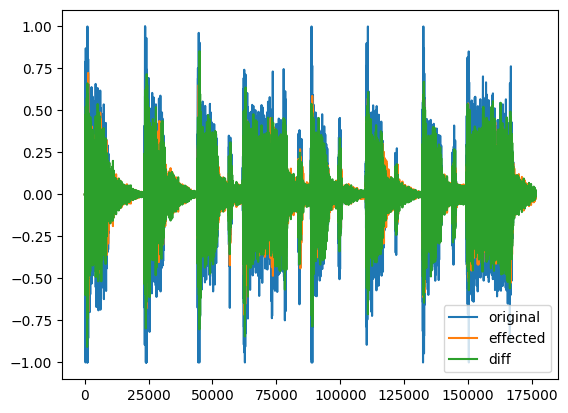

In [3]:
from pedalboard import Chorus, Reverb, Distortion

chorus = read_proces_dump('data/clean_guitar.wav', 
                 'data/chorus_guitar.wav', 
                 [Chorus(), Reverb(room_size=0.25)])

wav_player('data/chorus_guitar.wav')
chorus.plot()

### Processed to distortion

<AxesSubplot:>

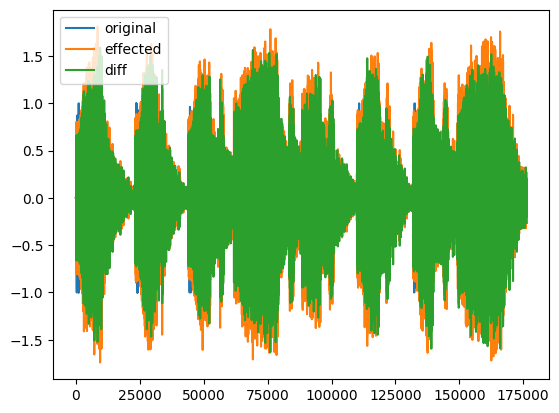

In [4]:
dist = read_proces_dump('data/clean_guitar.wav', 
                 'data/distortion_guitar.wav', 
                 [Distortion(), Reverb(room_size=0.25)])
wav_player('data/distortion_guitar.wav')
dist.plot()

# Preparing the data for keras
If need to package the data for use in a neural network. Because we want to let the neural network recreate the processing effects (chorus, distortion, etc), both the input and the output should be the audio clip. This makes me feels that I can't input the entire audio clip into a layer, but cut up the wav file into managable chunks. The chunk size is something to optimize. 

Luckily, the `read_proces_dump` function already returns both the input and the output wav files as a numpy array. Note that we resize to a chunk size of 512, and cut off the last little bit of the audio sample to get all multiples of 512:

In [45]:
chunk_size = 1024
wav_length = len(dist)
max_multiple = wav_length - (wav_length % chunk_size)
original_chunked = dist['original'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))   
effected_chunked = dist['effected'].to_numpy()[0:max_multiple].reshape((-1,chunk_size, 1))
print(original_chunked.shape)
print(effected_chunked.shape)


(172, 1024, 1)
(172, 1024, 1)


So this gives us 344 chunks of audio, each with 512 samples. 

# Building a model that can reproduce the distortion
The setup I'm thinking about right now is to create an encoder-decoder network which takes in the input audio, and spits out the output audio. The following is heavily inspired by a group of students I supervised:

In [46]:
from keras import Sequential, Model
import keras.layers as layers
import tensorflow as tf

model = Sequential(
    [
        layers.Conv1D(32, kernel_size=3, input_shape=(chunk_size,1), padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(),

        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(),
        
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(),

        layers.Conv1DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.Conv1DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.Conv1DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        layers.Conv1D(1, kernel_size=3, padding='same', activation='linear') # <---- needs to be linear and not relu to be able to generate negative numbers
    ]
)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 1024, 32)          128       
                                                                 
 conv1d_41 (Conv1D)          (None, 1024, 32)          3104      
                                                                 
 conv1d_42 (Conv1D)          (None, 1024, 32)          3104      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 512, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 512, 64)           6208      
                                                                 
 conv1d_44 (Conv1D)          (None, 512, 64)           12352     
                                                      

Our first step is to simply predict using the untrained model, this obviously will not really yield us any good results, but allow us to develop the tools and test what happens. First we just take one chunk, note we heavily resize to fit what this keras model wants `(1, chunk_size, 1)` if we just pass one example to predict on:

In [47]:
import numpy as np

untrained_prediction = model.predict(np.resize(original_chunked[:,2], (1, chunk_size, 1)))
untrained_prediction.shape

1/1 [==============================] - 1s 600ms/step


(1, 1024, 1)

Now we can process an entire audio clip and listen to the result of the untrained model. To process the entire audio clip we take the chunked data:

6/6 [==============================] - 1s 48ms/step


<AxesSubplot:>

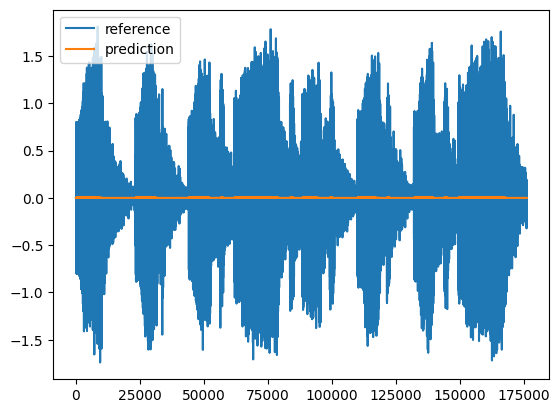

In [48]:
untrained_entire_clip = model.predict(np.resize(original_chunked, (original_chunked.size // chunk_size, chunk_size, 1)))
untrained_flat = untrained_entire_clip.flatten()
pd.DataFrame({'reference': dist['effected'][0:len(untrained_flat)], 'prediction': untrained_flat}).plot()

In [9]:
dump_numpy_audio(resize_to_mono(untrained_entire_clip),
                 reference_wav='data/clean_guitar.wav',
                 output_wav='data/untrained_distortion_guitar.wav')

This actually does not produce any audible sound. If you however dump `original_chunked` in the same way, you get the correct audio clip back, which indicates the function should work once we train the model. 

# Train the model with minimal data

In [49]:
from sklearn.model_selection import train_test_split

original_train, original_test, effected_train, effected_test = train_test_split(original_chunked, effected_chunked, test_size=0.2)
print(original_train.shape)
print(effected_train.shape)
print(original_test.shape)
print(effected_test.shape)

(137, 1024, 1)
(137, 1024, 1)
(35, 1024, 1)
(35, 1024, 1)


In [50]:
history = model.fit(original_train, effected_train, epochs=100, batch_size=4, validation_data=(original_test, effected_test))

Epoch 1/100
35/35 [==============================] - 3s 44ms/step - loss: 0.2959 - val_loss: 0.2777
Epoch 2/100
35/35 [==============================] - 1s 24ms/step - loss: 0.2461 - val_loss: 0.1717
Epoch 3/100
35/35 [==============================] - 1s 22ms/step - loss: 0.1445 - val_loss: 0.1173
Epoch 4/100
35/35 [==============================] - 1s 25ms/step - loss: 0.1144 - val_loss: 0.1019
Epoch 5/100
35/35 [==============================] - 1s 21ms/step - loss: 0.1029 - val_loss: 0.0936
Epoch 6/100
35/35 [==============================] - 1s 23ms/step - loss: 0.0956 - val_loss: 0.0858
Epoch 7/100
35/35 [==============================] - 1s 22ms/step - loss: 0.0887 - val_loss: 0.0794
Epoch 8/100
35/35 [==============================] - 1s 24ms/step - loss: 0.0839 - val_loss: 0.0751
Epoch 9/100
35/35 [==============================] - 1s 23ms/step - loss: 0.0793 - val_loss: 0.0712
Epoch 10/100
35/35 [==============================] - 1s 23ms/step - loss: 0.0753 - val_loss: 0.0686

<AxesSubplot:xlabel='Epoch'>

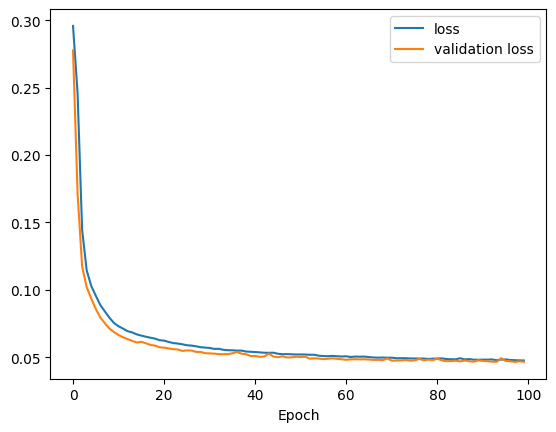

In [51]:
plot_loss(history)

In [52]:
trained_entire_clip = model.predict(np.resize(original_chunked, (original_chunked.size // chunk_size, chunk_size, 1)))
dump_numpy_audio(resize_to_mono(trained_entire_clip),
                 reference_wav='data/clean_guitar.wav',
                 output_wav='data/trained_distortion_guitar.wav')
wav_player('data/trained_distortion_guitar.wav')

6/6 [==============================] - 0s 34ms/step


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

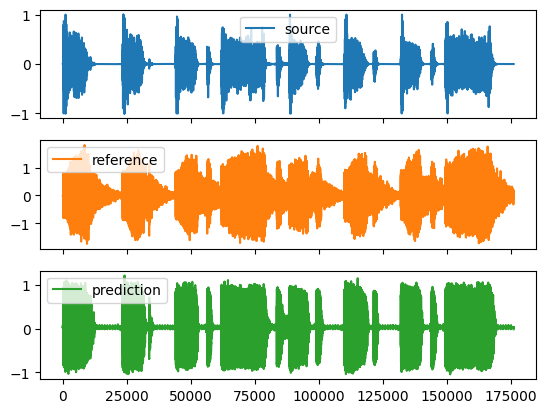

In [56]:
trained_flat = trained_entire_clip.flatten()
pd.DataFrame({'source': dist['original'][0:len(trained_flat)], 
              'reference': dist['effected'][0:len(trained_flat)], 
              'prediction': trained_flat}).plot(subplots=True)